In [1]:
from uwnet.stochastic_parameterization.residual_stochastic_state_model import StochasticStateModel
from uwnet.stochastic_parameterization.examine_stochastic_state_model import (
    compare_true_to_simulated_q1_q2_distributions,
)
from uwnet.stochastic_parameterization.utils import default_eta_transitioner_predictors
dir_ = '/Users/stewart/projects/uwnet/uwnet/stochastic_parameterization/'
base_model_location = dir_ + 'full_model/1.pkl'
ds_location = dir_ + 'training.nc'
kwargs_ = {
    'base_model_location': base_model_location,
    'ds_location': ds_location,
    'verbose': False}
eta_transitoner_predictors_with_state = ['moistening_pred', 'heating_pred'] + default_eta_transitioner_predictors
%matplotlib inline

We see that the when simulated etas are used, the correct PDF for the SLI and QT is not produced by the neural network. However, when the true etas are used, the PDF matches the true PDF almost perfectly. This tells us that the eta transitioner scheme is to blame for the incorrect PDF. In particular, the extreme values of the PDF of SLI and PDF are not produced when simulated bin transitions are used. Below is using the model configuration that was developed prior to when this notebook was created:

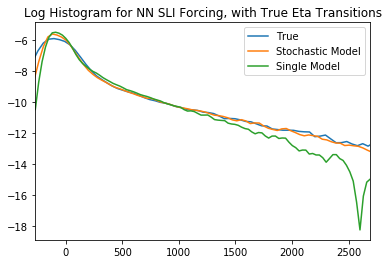

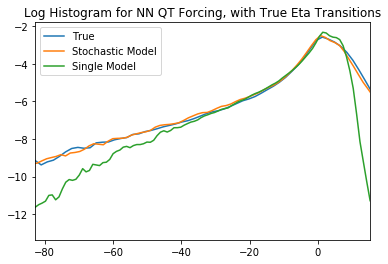

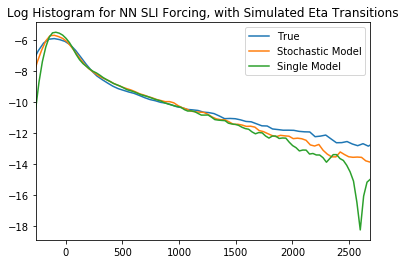

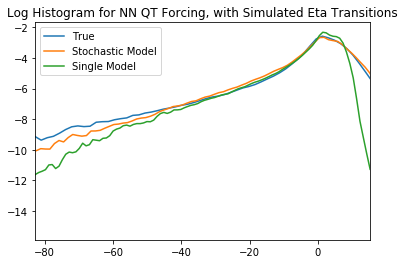

['SST', 'PW', 'QT', 'SLI', 'SOLIN']


In [2]:
model_1 = StochasticStateModel(
    markov_process=True,
    include_output_in_transition_model=False,
    eta_predictors=default_eta_transitioner_predictors,
    **kwargs_
)
model_1.train()
compare_true_to_simulated_q1_q2_distributions(model_1, true_etas=True, print_stats=False)
compare_true_to_simulated_q1_q2_distributions(model_1, true_etas=False, print_stats=False)
print(model_1.eta_transitioner.predictors)

When the output of the model is included as the input of the eta transitioner model, the PDF of the stochastic model gets closer to the true PDF:

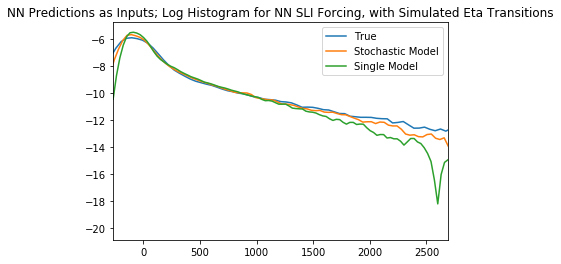

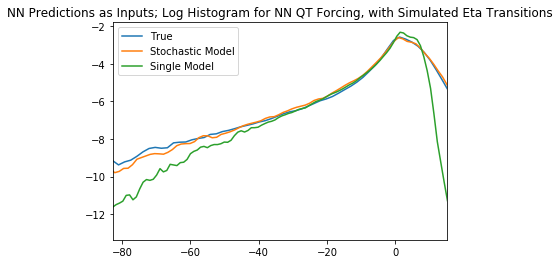

['moistening_pred', 'heating_pred', 'SST', 'PW', 'QT', 'SLI', 'SOLIN']


In [3]:
model_2 = StochasticStateModel(
    markov_process=True,
    include_output_in_transition_model=True,
    eta_predictors=eta_transitoner_predictors_with_state,
    **kwargs_
)
model_2.train()
compare_true_to_simulated_q1_q2_distributions(
    model_2, true_etas=False, print_stats=False, title_prefix='NN Predictions as Inputs; ')
print(model_2.eta_transitioner.predictors)

I noticed that when the current eta state is removed as an input to the eta transitioner logistic regression model, the PDF improved drastically, nearly matching the performance of the true eta pdf. The problem with this methodology is that the transitioner is no longer a markov process.

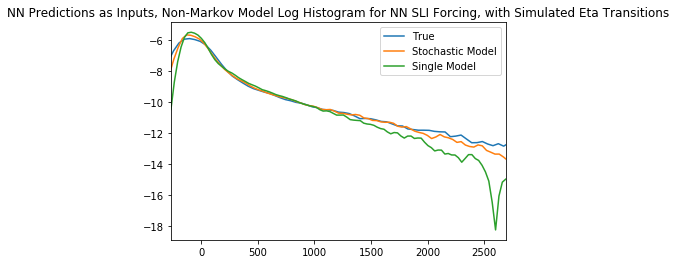

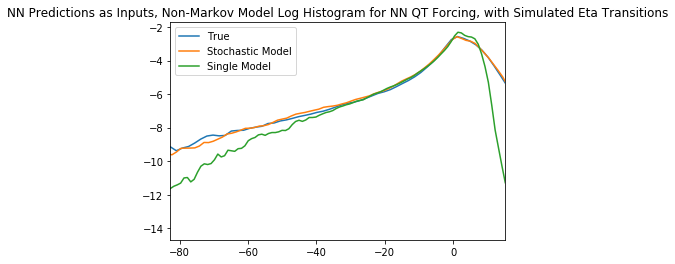

['moistening_pred', 'heating_pred', 'SST', 'PW', 'QT', 'SLI', 'SOLIN']


In [4]:
model_3 = StochasticStateModel(
    markov_process=False,
    include_output_in_transition_model=True,
    eta_predictors=eta_transitoner_predictors_with_state,
    **kwargs_
)
model_3.train()
compare_true_to_simulated_q1_q2_distributions(
    model_3, true_etas=False, print_stats=False, title_prefix='NN Predictions as Inputs, Non-Markov Model ')
print(model_3.eta_transitioner.predictors)

If the current eta is not included in the transition scheme, including the NN output as an input to the transitioner model helps a lot. Notice how much worse the distribution is without the NN output as an input to the transitioner: 

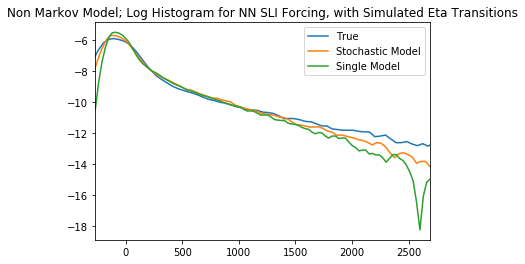

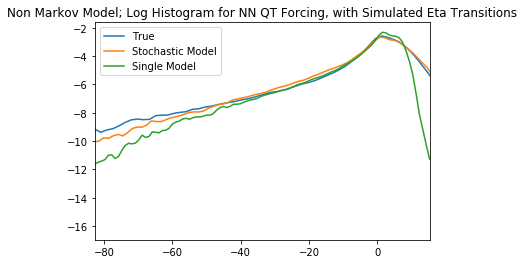

['SST', 'PW', 'QT', 'SLI', 'SOLIN']


In [5]:
model_4 = StochasticStateModel(
    markov_process=False,
    include_output_in_transition_model=False,
    eta_predictors=default_eta_transitioner_predictors,
    **kwargs_
)
model_4.train()
compare_true_to_simulated_q1_q2_distributions(
    model_4, true_etas=False, print_stats=False, title_prefix='Non Markov Model; ')
print(model_4.eta_transitioner.predictors)

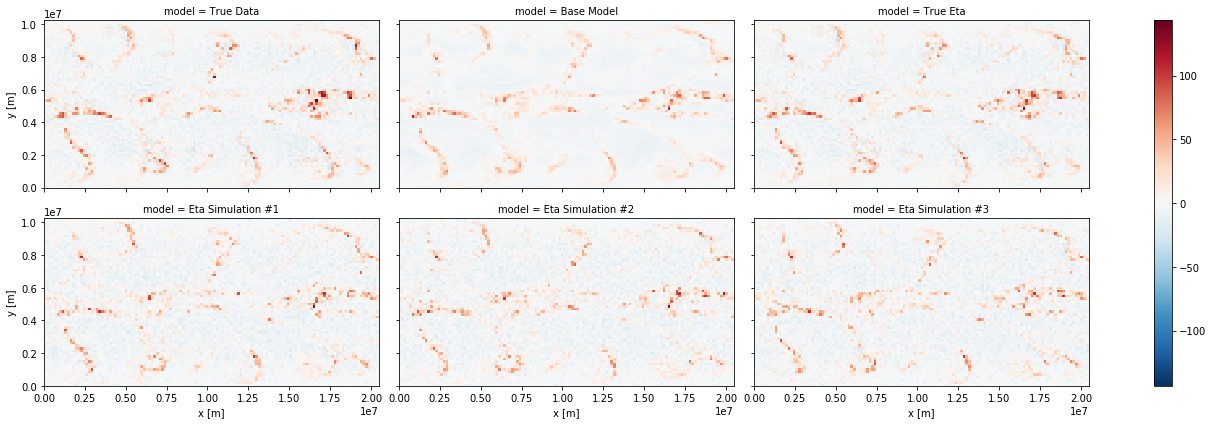

In [9]:
from uwnet.stochastic_parameterization.analyze_eta_transitioner import plot_predicted_q2, base_model
model_3 = StochasticStateModel(
    markov_process=False,
    include_output_in_transition_model=True,
    time_idx_to_use_for_eta_initialization=0,
    eta_predictors=eta_transitoner_predictors_with_state,
    **kwargs_
)
model_3.train()
plot_predicted_q2(base_model, model_3)